<a href="https://colab.research.google.com/github/stefvas/neural-networks/blob/main/Team40_Ergasia2_UnsupervisedLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Εργαστηριακή Άσκηση 2. Μη επιβλεπόμενη μάθηση. 

## Σύστημα συστάσεων βασισμένο στο περιεχόμενο
## Σημασιολογική απεικόνιση δεδομένων με χρήση SOM 



Ομάδα 40

Βασιλειάδης Στέφανος 03117434


Παναγιωτακοπούλου Άννα 03116057


Παπαβασιλόπουλος Παναγιώτης-Φίλιππος 03117444


In [ ]:
!pip install --upgrade pip
!pip install --upgrade numpy
!pip install --upgrade pandas
!pip install --upgrade nltk
!pip install --upgrade scikit-learn
!pip install --upgrade joblib

## Εισαγωγή του Dataset

Το σύνολο δεδομένων με το οποίο θα δουλέψουμε είναι βασισμένο στο [Carnegie Mellon Movie Summary Corpus](http://www.cs.cmu.edu/~ark/personas/). Πρόκειται για ένα dataset με 22.301 περιγραφές ταινιών. Η περιγραφή κάθε ταινίας αποτελείται από τον τίτλο της, μια ή περισσότερες ετικέτες που χαρακτηρίζουν το είδος της ταινίας και τέλος τη σύνοψη της υπόθεσής της. Αρχικά εισάγουμε το dataset (χρησιμοποιήστε αυτούσιο τον κώδικα, δεν χρειάζεστε το αρχείο csv) στο dataframe `df_data_1`: 

In [ ]:
import pandas as pd

dataset_url = "https://drive.google.com/uc?export=download&id=1-tN5rC1QCgwqL67cvIXdMbtd-Xf9Xqow"
df_data_1 = pd.read_csv(dataset_url, sep='\t',  header=None, quoting=3, error_bad_lines=False)

In [ ]:
import numpy as np

# βάλτε το seed που αντιστοιχεί στην ομάδα σας
team_seed_number = 40

movie_seeds_url = "https://drive.google.com/uc?export=download&id=1-oeMf7BFmiH70XObgC9WOTo-a9cDJZwP"
df_data_2 = pd.read_csv(movie_seeds_url, header=None, error_bad_lines=False)

# επιλέγεται 
my_index = df_data_2.iloc[team_seed_number,:].values

titles = df_data_1.iloc[:, [2]].values[my_index] # movie titles (string), list of 5000
categories = df_data_1.iloc[:, [3]].values[my_index] # movie categories (string), list of 5000
bins = df_data_1.iloc[:, [4]]
catbins = bins[4].str.split(',', expand=True).values.astype(np.float)[my_index] # movie categories in binary form (1 feature per category), array of 5000*322
summaries =  df_data_1.iloc[:, [5]].values[my_index] # movie summaries (string)
corpus = summaries[:,0].tolist() # list form of summaries

In [ ]:
#print(type(corpus))
punc = '''!@#$%^&*(){}[];:?/.,\|`~_-'''
def simplify_lower(arr):
  corpus_prime = []
  for string in arr:
    temp  = ""
    for char in string:
      if (char.isupper()):
         char = char.lower()
      temp += char
    string = temp
    corpus_prime.append(string)
  return corpus_prime


def simplify_punc(arr):
  corpus_prime = []
  for string in arr:
    temp  = ""
    for char in string:
      if(char in punc):
       count = 0
      else:
        temp += char
    string = temp
    corpus_prime.append(string)
  return corpus_prime

corpus = simplify_lower(corpus)

corpus = simplify_punc(corpus)


In [ ]:
ID = 99
print(titles[ID])
print(categories[ID])
print(catbins[ID])
print(corpus[ID])

# Εφαρμογή 1. Υλοποίηση συστήματος συστάσεων ταινιών βασισμένο στο περιεχόμενο
<img src="http://clture.org/wp-content/uploads/2015/12/Netflix-Streaming-End-of-Year-Posts.jpg" width="70%">

Η πρώτη εφαρμογή που θα αναπτύξετε θα είναι ένα [σύστημα συστάσεων](https://en.wikipedia.org/wiki/Recommender_system) ταινιών βασισμένο στο περιεχόμενο (content based recommender system). Τα συστήματα συστάσεων στοχεύουν στο να προτείνουν αυτόματα στο χρήστη αντικείμενα από μια συλλογή τα οποία ιδανικά θέλουμε να βρει ενδιαφέροντα ο χρήστης. Η κατηγοριοποίηση των συστημάτων συστάσεων βασίζεται στο πώς γίνεται η επιλογή (filtering) των συστηνόμενων αντικειμένων. Οι δύο κύριες κατηγορίες είναι η συνεργατική διήθηση (collaborative filtering) όπου το σύστημα προτείνει στο χρήστη αντικείμενα που έχουν αξιολογηθεί θετικά από χρήστες που έχουν παρόμοιο με αυτόν ιστορικό αξιολογήσεων και η διήθηση με βάση το περιεχόμενο (content based filtering), όπου προτείνονται στο χρήστη αντικείμενα με παρόμοιο περιεχόμενο (με βάση κάποια χαρακτηριστικά) με αυτά που έχει προηγουμένως αξιολογήσει θετικά.

Το σύστημα συστάσεων που θα αναπτύξετε θα βασίζεται στο **περιεχόμενο** και συγκεκριμένα στις συνόψεις των ταινιών (corpus). 


## Μετατροπή σε TFIDF



Αλλάζουμε τις παραμέτρους δίνοντάς μας τη δυνατότητα να προσθέσουμε και δικιές μας stopwords.

In [ ]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as stopwords_english
from sklearn.feature_extraction.text import TfidfVectorizer

def tf_idf(mx_df, mn_df, my_stopwrods=list()):

  stopwords_film = ["movie", "film", "plot", "begins", "opens", "starts", "piece", "named", "woman", "women", "man", "men", "prologue", "help", "helping"]
  stopwords = list(stopwords_english) + list(my_stopwrods) + list(stopwords_film)# enhancing stopwords

  vectorizer = TfidfVectorizer(max_df=mx_df, min_df=mn_df, stop_words=stopwords, analyzer='word')
  vectorizer.fit(corpus)
  corpus_tf_idf = vectorizer.transform(corpus)
  print("Dimensions: ", corpus_tf_idf.shape, "\n")


  return corpus_tf_idf

In [ ]:
print(tf_idf(1.0, 0))

Dimensions:  (5000, 48562) 

  (0, 48201)	0.014812574193456204
  (0, 48200)	0.00915044086645136
  (0, 48073)	0.022625168225707294
  (0, 47947)	0.025741211048127557
  (0, 47860)	0.026892610320732747
  (0, 47849)	0.018612878156061618
  (0, 47839)	0.020056063814802072
  (0, 47785)	0.01920856612258464
  (0, 47776)	0.010856472332805019
  (0, 47587)	0.04376066659775111
  (0, 47515)	0.030438890292083555
  (0, 47487)	0.018062076007015374
  (0, 47483)	0.23827253234557133
  (0, 47415)	0.018705590764114047
  (0, 47026)	0.015737258733096456
  (0, 46922)	0.01102084580162583
  (0, 46918)	0.03235210054230669
  (0, 46728)	0.01843429402593167
  (0, 46583)	0.0343243381010756
  (0, 45845)	0.02438647180980415
  (0, 45784)	0.02505826195732574
  (0, 45776)	0.01289592071558338
  (0, 45769)	0.012739297269325862
  (0, 45320)	0.024869267058576432
  (0, 45253)	0.0193181379503111
  :	:
  (4999, 8720)	0.01890417600405281
  (4999, 8300)	0.038972314127411756
  (4999, 7904)	0.01969591838327934
  (4999, 7901)	0.016287

## Υλοποίηση του συστήματος συστάσεων


In [ ]:
# function that prints movie info
def print_movie(ID):
  print("ID: ", ID)
  print("Title: ", ', '.join(titles[ID]))
  print("Categories: ", ', '.join(categories[ID]))
  print("Summary:\n", corpus[ID], "\n")

In [ ]:
from sklearn.metrics.pairwise import linear_kernel

def content_recommender(ID, max_recommendations):
  cosine_similarities = linear_kernel(corpus_tf_idf[ID], corpus_tf_idf).flatten()  # calculating cosine similarities using sparse matrices

  cosine_similarities = (-cosine_similarities).argsort()  # sorting the array and saving movies based on ID's

  print_movie(ID)  # print target movie info

  for i in range(1, max_recommendations+1):   # print recommendations
    print("Place:", i)
    print_movie(cosine_similarities[i])

Ένα παράδειγμα χρήσης για την 2η ταινία και 5 recommendations:

In [ ]:
corpus_tf_idf = tf_idf(1.0, 0)

Dimensions:  (5000, 48562) 



In [ ]:
content_recommender(1, 5)

ID:  1
Title:  Restless
Categories:  "Comedy",  "World cinema",  "Chinese Movies"
Summary:
 Leah  is a translator who is traveling international cities in search of romance and closure with her estranged boyfriend Jeff. She eventually settles in Beijing, China, where she meets and develops a fixation on Master Sun Zhan , who teaches here a Chinese game called weiqi. When her relationship with Master Sun Zhan takes a turn for the worse, Leah decides to focus on getting revenge on Jeff. Richard  is a shiftless Chinese-American whose family sends him to Beijing with his grandfather's ashes. Eventually Leah and Richard's paths cross and a romance develops. 

Place: 1
ID:  2737
Title:  Eyes of Fire
Categories:  "Horror"
Summary:
 The film takes place in the year 1750 on the American frontier during the colonial days, before the United States declared its independence. A group of pioneers narrowly escape persecution when their preacher is accused of adultery and polygamy. The preacher, Will 

## Βελτιστοποίηση

Αφού υλοποιήσετε τη συνάρτηση `content_recommender` χρησιμοποιήστε τη για να βελτιστοποιήσετε την `TfidfVectorizer`. Συγκεκριμένα, αρχικά μπορείτε να δείτε τι επιστρέφει το σύστημα για τυχαίες ταινίες-στόχους και για ένα μικρό `max_recommendations` (2 ή 3). Αν σε κάποιες ταινίες το σύστημα μοιάζει να επιστρέφει σημασιολογικά κοντινές ταινίες σημειώστε το `ID` τους. Δοκιμάστε στη συνέχεια να βελτιστοποιήσετε την `TfidfVectorizer` για τα συγκεκριμένα `ID` ώστε να επιστρέφονται σημασιολογικά κοντινές ταινίες για μεγαλύτερο αριθμό `max_recommendations`. Παράλληλα, όσο βελτιστοποιείτε την `TfidfVectorizer`, θα πρέπει να λαμβάνετε καλές συστάσεις για μεγαλύτερο αριθμό τυχαίων ταινιών. Μπορείτε επίσης να βελτιστοποιήσετε τη συνάρτηση παρατηρώντας πολλά φαινόμενα που το σύστημα εκλαμβάνει ως ομοιότητα περιεχομένου ενώ επί της ουσίας δεν είναι επιθυμητό να συνυπολογίζονται . Ταυτόχρονα, μια άλλη κατεύθυνση της βελτιστοποίησης είναι να χρησιμοποιείτε τις παραμέτρους του `TfidfVectorizer` έτσι ώστε να μειώνονται οι διαστάσεις του Vector Space Model μέχρι το σημείο που θα αρχίσει να εμφανίζονται επιπτώσεις στην ποιότητα των συστάσεων. 

------------------------------------------------------------------------------


Ορίζουμε την συνάρτηση similar_movies οι οποία μας επιστρέφει το σύνολο των ταινιών στόχων, για τις οποίες οι πρώτες 3 επιλογές ανήκαν σε count (count είναι η παράμετρος που της δίνουμε) είδη όμοια με την πρώτη. Εκτός των υπολοίπων μεθόδων συμβουλευόμαστε και αυτήν την μετρική και με τη μεγιστοποίηση της συνάρτησης αυτής προσπαθούμε να βελτιστοποιήσουμε τον Tfidfvectorizer.

In [ ]:
def similar_movies(count):
  movie_list = []

  for i in range(0, 5000): # for all movies
    cnt = count

    cosine_similarities = linear_kernel(corpus_tf_idf[i], corpus_tf_idf).flatten()  # find best matches
    cosine_similarities = (-cosine_similarities).argsort()
    
    categs = categories[i][0]
    categs = categs.split(",")
    
    for category in categs: # find categories similar between th movie and the 3 top matches
      if category.lstrip(' ') in (categories[cosine_similarities[1]][0]) and category.lstrip(' ') in (categories[cosine_similarities[2]][0]) and category.lstrip(' ') in (categories[cosine_similarities[3]][0]):
        cnt = cnt - 1
      if cnt == 0: # if count similar categories are found append the movie to movie_list
        movie_list.append(i)
        break

  return movie_list

Εμπλουτίζουμε τις stop words με αγγλικά ονόματα. Έτσι οι ομοιότητες μεταξύ ταινιών δεν θα οφείλονται σε κοινά ονόματα χαρακτήρων τους. Εξηγούμε παρακάτω γιατί προέκυψε η ανάγκη πρόσθεσής τους.

In [ ]:
import urllib.request 
import string

# female english names
target_url = "http://www.cs.cmu.edu/Groups/AI/util/areas/nlp/corpora/names/female.txt"
response = urllib.request.urlopen(target_url).read().decode()
lines_temp = response.split('\n')
names = []

for line in lines_temp:
  if line and line[0] != "#":
    names.append(line.lower())

# male english names
target_url = "http://www.cs.cmu.edu/Groups/AI/util/areas/nlp/corpora/names/male.txt"
response = urllib.request.urlopen(target_url).read().decode()
lines_temp = response.split('\n')

for line in lines_temp:
  if line and line[0] != "#":
    names.append(line.lower())


Παρατηρούμε μείωση στη διαστατικότητα κατά 3000 περίπου. Δηλαδή έφυγαν 3000 ονόματα που αναφέρονταν στους πρωταγωνιστές των ταινιών.

In [ ]:
corpus_tf_idf = tf_idf(1.0, 0, names)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['luc', 'mar', 'zsa'] not in stop_words.
  % sorted(inconsistent)


Dimensions:  (5000, 45559) 



## Επεξήγηση επιλογών και ποιοτική ερμηνεία

-------------------------------------------------------------------------------

Αρχικά παρατηρήσαμε πως σε πολλές περιπτώσεις οι παρόμοιες ταινίες οφείλονταν σε κοινά ονόματα χαρακτήρων τους. Έτσι ενισχύσαμε τις stopwords με αγγλικά ονόματα ώστε να μην εντοπίζονται αυτές οι ομοιότητες. 


In [ ]:
corpus_tf_idf = tf_idf(1.0, 0)

Dimensions:  (5000, 48562) 



Παρακάτω φαίνεται το πρόβλημα που δημιουργείται εξαιτίας των ονομάτων. Όπως φαίνεται ο πρωταγωνιστής της ταινία στόχου ονομάζεται Ben. Επειδή το όνομα λαμβάνεται υπόψην ως λέξη παρατηρούμε οτι και οι 3 πρώτες ταινίες περιέχουν επίσης αυτό το όνομα. Αυτό σημαίνει οτι ίσως να υπάρχουν σχετικότερες ταινίες με την ταινία στόχο, οι οποίες να υποβαθμίζονται λόγω αυτών των ομοιοτήτων.

In [ ]:
content_recommender(10, 3)

ID:  10
Title:  Como Esquecer
Categories:  "Drama"
Summary:
 Julia  is a professor of English literature who is abandoned by her girlfriend after a relationship that lasted over ten years. Because of the separation, Julie moves to Rio de Janeiro and lives with her best friend, Hugo , who is gay, and Lisa . In the new work, Julia ends up attracting the interest of two students, and it is Helena  who is after the teacher, although she did not feel prepared for a new relationship. 

Place: 1
ID:  3368
Title:  Date Movie
Categories:  "Romantic comedy",  "Parody",  "Romance Film",  "Comedy"
Summary:
  Julia Jones is an obese woman, who dreams of marrying Napoleon Dynamite, but even in her dreams she is rejected. Writing in her diary, she thinks she will never find her true love. Julia goes outside and dances to impress men on the streets. It doesn't, as her obesity gets the best of her. Later on, Julia goes to work at her dad's Greek diner. Her dad, Frank, suggests she gets married to someo

In [ ]:
corpus_tf_idf = tf_idf(1.0, 0, names)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['luc', 'mar', 'zsa'] not in stop_words.
  % sorted(inconsistent)


Dimensions:  (5000, 45559) 



Παρατηρούμε οτι οι επιλογές είναι αρκετά πιο σχετικές καθώς όλες αφορούν τις ζωές ατόμων μικρών σε ηλικία (εκτός της πρώτης επιλογής, στην οποία η σύνδεση είναι η λέξη "time" αλλά λόγω του σεναρίου αφορά, τεχνικά, άτομα ηλικιακά νέα).

In [ ]:
content_recommender(10, 3)

ID:  10
Title:  Como Esquecer
Categories:  "Drama"
Summary:
 Julia  is a professor of English literature who is abandoned by her girlfriend after a relationship that lasted over ten years. Because of the separation, Julie moves to Rio de Janeiro and lives with her best friend, Hugo , who is gay, and Lisa . In the new work, Julia ends up attracting the interest of two students, and it is Helena  who is after the teacher, although she did not feel prepared for a new relationship. 

Place: 1
ID:  4711
Title:  Only When I Dance
Categories:  "Documentary"
Summary:
 Only When I Dance tells the story of two teenagers, Irlan and Isabela, who pursue their dreams of becoming professional ballet dancers as a way to escape the violent slums of Rio de Janeiro. 

Place: 2
ID:  3855
Title:  Love, in between
Categories:  "Romance Film",  "Drama"
Summary:
 When the wife of a university professor discovered her husband is having affair with his student she meets his lover they become friends and the rel

Αργότερα προσθέσαμε στις stopwords λέξεις όπως τις "film", "movie", "begins" κλπ που εμφανίζονται συχνά σε περιλήψεις ταινίων.

Πράγματι μετά από αυτές τις διορθώσεις οι περιπτώσεις, στις οποίες οι τρεις πρώτες επιλογές είχαν όλες τουλάχιστον μία ίδια κατηγορία με την ταινία στόχο έγιναν, από 667, 738.

Μετά πήραμε από τη λίστα με τις 738 ταινίες που βρήκαμε παραπάνω, περιπτώσεις (60, 78, 83, 95, 103, 115, 138), οι οποίες ήταν καλές και προσπαθήσαμε να βελτιώσουμε περαιτέρω τις εκτιμήσεις. Παρατηρώντας τα αποτελέσματα αποφασίσαμε να εξαιρέσουμε μερικές ακόμα λέξεις: "begins", "opens", "starts", "piece", "named", "woman", "women", "man", "men", "prologue", "help", "helping". Έτσι αναβάσαμε τον παραπάνω αριθμό σε 746.

Corpus με τις film_stopwords. Έχουμε μείωση κατά 15 λέξεις.

In [ ]:
corpus_tf_idf = tf_idf(1.0, 0, names)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['luc', 'mar', 'zsa'] not in stop_words.
  % sorted(inconsistent)


Dimensions:  (5000, 45559) 



### min_df

Η χρήση μόνο των λιγότερο συχνών λέξεων, με μείωση του max_df, αποδείχθηκε οτι δε βοηθά, καθώς μόλις οδηγούσε σε μείωση των λέξεων του λεξιλογίου υπήρχε άμεση χειροτέρευση της ποιότητας των αποτελεσμάτων.

Ο αποκλεισμός των λιγότερο συχνών λέξεων βοηθά σε κάποιες περιπτώσεις καθώς αποκλείει σπάνιες λέξεις που δεν προσφέρουν στο νόημα, ενώ σε άλλες κάνει το ίδιο αλλά με λέξεις που συσχετίζουν μικρό αριθμό ταινιών της ίδιας κατηγορίας οδηγώντας σε χειρότερα αποτελέσματα.<br>
Παρακάτω φαίνονται 1 περίπτωση, στην οποία ισχύει το πρώτο και μία στην οποία ισχύει το δεύτερο:

In [ ]:
corpus_tf_idf = tf_idf(1.0, 2, names)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['luc', 'mar', 'zsa'] not in stop_words.
  % sorted(inconsistent)


Dimensions:  (5000, 22761) 



In [ ]:
content_recommender(83, 3)

ID:  83
Title:  Follow that Dream
Categories:  "Musical",  "Comedy"
Summary:
 A vagabond family composed of Pop Kwimper , his son Toby , and various "adopted" children, including nineteen-year-old Holly Jones , is traveling in Florida when Pop drives onto an as-yet-unopened section of highway. When the car runs out of gas, Holly persuades Toby to persuade Pop to take up residence on the land next to the road. A chance encounter with an avid fisherman  gives Holly an idea. They build a thriving business catering to sports fishermen. Trouble soon follows. Toby rejects the advances of amorous social worker Alisha Claypoole , who goes to court to have the children taken away in revenge. Also, her government official boyfriend considers the squatters' home to be an eyesore and wants to evict them. Finally, since the area is outside the jurisdiction of any law enforcement, two gamblers  soon set up a casino in a trailer, and Toby has to deal with their armed thugs. In the end, Toby's earthy 

Όπως φαίνεται η ταινία είναι δραματική και σχετίζεται με το έγκλημα, όπως και η 1η και η 2η επιλογή. Αντίθετα η 3η δεν σχετίζεται με το έγκλημα. <br>
Αυξάνουμε το min_dfQ:

In [ ]:
corpus_tf_idf = tf_idf(1.0, 15, names)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['luc', 'mar', 'zsa'] not in stop_words.
  % sorted(inconsistent)


Dimensions:  (5000, 5596) 



In [ ]:
content_recommender(83, 3)

ID:  83
Title:  Follow that Dream
Categories:  "Musical",  "Comedy"
Summary:
 A vagabond family composed of Pop Kwimper , his son Toby , and various "adopted" children, including nineteen-year-old Holly Jones , is traveling in Florida when Pop drives onto an as-yet-unopened section of highway. When the car runs out of gas, Holly persuades Toby to persuade Pop to take up residence on the land next to the road. A chance encounter with an avid fisherman  gives Holly an idea. They build a thriving business catering to sports fishermen. Trouble soon follows. Toby rejects the advances of amorous social worker Alisha Claypoole , who goes to court to have the children taken away in revenge. Also, her government official boyfriend considers the squatters' home to be an eyesore and wants to evict them. Finally, since the area is outside the jurisdiction of any law enforcement, two gamblers  soon set up a casino in a trailer, and Toby has to deal with their armed thugs. In the end, Toby's earthy 

Πια και η 3η ταινία έχει σχετικό περιεχόμενο.

Αντίθετα υπάρχουν περιπτώσεις όπου αυτή η τακτική δημιουργεί πρόβλημα:

In [ ]:
corpus_tf_idf = tf_idf(1.0, 2, names)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['luc', 'mar', 'zsa'] not in stop_words.
  % sorted(inconsistent)


Dimensions:  (5000, 22761) 



In [ ]:
content_recommender(95, 3)

ID:  95
Title:  Missing in Action 2: The Beginning
Categories:  "Action",  "Adventure",  "Escape Film"
Summary:
 Ten years before freeing American POWs from a brutal General, Colonel James Braddock  was held in a North Vietnamese POW camp run by sadistic Colonel Yin , who forces the POWs to grow opium for a French drug runner named Francois , and tries to get Braddock to admit to and sign a long list of war crimes. During his team's time in captivity, they are relentlessly subjected to various forms of humiliating torture, and Braddock being told that his wife has left him and has remarried. One of Braddock's comrades starts to suffer with malaria, and is injected with what they are told to be antibiotics. They later find out that he was in fact injected with a lethal dose of opium instead. Braddock must escape and rescue his fellow prisoners from Yin. 

Place: 1
ID:  988
Title:  The Great Raid
Categories:  "Action",  "Drama",  "War film"
Summary:
 In 1944, American forces were closing

Η ταινία αφορά 2 αδελφές, την Πένυ και την Μαίρη και τις δυσκολίες που περνάνε.<br>
Η 1η ταινία είναι μυστηρίου. Η 2η είναι δραματική, όπως και η πρώτη, αλλά και κωμωδία και η 3η έχει κάποιες ομοιότητες με την ταινία στόχο, αλλά έχει πιο ρομαντικό χαρακτήρα.

In [ ]:
corpus_tf_idf = tf_idf(1.0, 5, names)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['luc', 'mar', 'zsa'] not in stop_words.
  % sorted(inconsistent)


Dimensions:  (5000, 12032) 



In [ ]:
content_recommender(95, 3)

ID:  95
Title:  Missing in Action 2: The Beginning
Categories:  "Action",  "Adventure",  "Escape Film"
Summary:
 Ten years before freeing American POWs from a brutal General, Colonel James Braddock  was held in a North Vietnamese POW camp run by sadistic Colonel Yin , who forces the POWs to grow opium for a French drug runner named Francois , and tries to get Braddock to admit to and sign a long list of war crimes. During his team's time in captivity, they are relentlessly subjected to various forms of humiliating torture, and Braddock being told that his wife has left him and has remarried. One of Braddock's comrades starts to suffer with malaria, and is injected with what they are told to be antibiotics. They later find out that he was in fact injected with a lethal dose of opium instead. Braddock must escape and rescue his fellow prisoners from Yin. 

Place: 1
ID:  988
Title:  The Great Raid
Categories:  "Action",  "Drama",  "War film"
Summary:
 In 1944, American forces were closing

Αφαιρούνται οι πιο σχετικές 2η και 3η επιλογή και προστίθενται στην 1η και 3η θέση ταινίες, με την 3η να μην είναι καθόλου σχετική.

Συνεχίσαμε τις δοκιμές και καταλήξαμε κοντά σε μία τιμή 5-6 στο min-df, στην οποία παίρναμε καλά αποτελέσματα, χωρίς να χαλάνε τα αποτελέσματα. 

Για να επιβεβαιώσουμε την σωστή τιμή του min_df, η οποία επηρεάζει τη διαστατικότητα του πίνακα και άρα και το χρόνο εκπαίδευσης εκτυπώνουμε τα μεγέθη των λιστών που δίνει η συνάρτηση similar_movies που φτιάξαμε, συναρτήσει της min_df, για αριθμό κοινών ειδών μεταξύ των ταινιών 2 και 3.

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['luc', 'mar', 'zsa'] not in stop_words.
  % sorted(inconsistent)


Dimensions:  (5000, 45559) 



/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['luc', 'mar', 'zsa'] not in stop_words.
  % sorted(inconsistent)


Dimensions:  (5000, 22761) 



/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['luc', 'mar', 'zsa'] not in stop_words.
  % sorted(inconsistent)


Dimensions:  (5000, 16968) 



/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['luc', 'mar', 'zsa'] not in stop_words.
  % sorted(inconsistent)


Dimensions:  (5000, 13961) 



/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['luc', 'mar', 'zsa'] not in stop_words.
  % sorted(inconsistent)


Dimensions:  (5000, 12032) 



/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['luc', 'mar', 'zsa'] not in stop_words.
  % sorted(inconsistent)


Dimensions:  (5000, 10673) 



/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['luc', 'mar', 'zsa'] not in stop_words.
  % sorted(inconsistent)


Dimensions:  (5000, 9653) 



/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['luc', 'mar', 'zsa'] not in stop_words.
  % sorted(inconsistent)


Dimensions:  (5000, 8792) 



/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['luc', 'mar', 'zsa'] not in stop_words.
  % sorted(inconsistent)


Dimensions:  (5000, 8111) 



/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['luc', 'mar', 'zsa'] not in stop_words.
  % sorted(inconsistent)


Dimensions:  (5000, 7551) 



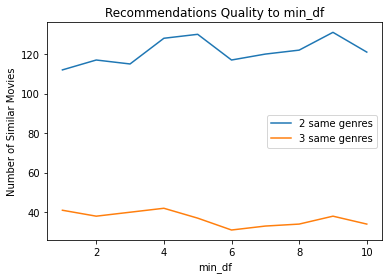

In [ ]:
import matplotlib.pyplot as plt

length_2 = []
length_3 = []
min_dfs = [1,2,3,4,5,6,7,8,9,10]
for min_df in min_dfs:
  corpus_tf_idf = tf_idf(1.0, min_df, names)
  temp = []
  length_2.append(len(similar_movies(2)))
  length_3.append(len(similar_movies(3)))
  

plt.plot(min_dfs, length_2)
plt.plot(min_dfs, length_3)
plt.xlabel('min_df')
plt.ylabel('Number of Similar Movies')
plt.title('Recommendations Quality to min_df')
plt.legend(['2 same genres', '3 same genres'], loc='center right')
plt.show()

In [ ]:
print(length_2)
print(length_3)

[112, 117, 115, 128, 130, 117, 120, 122, 131, 121]
[41, 38, 40, 42, 37, 31, 33, 34, 38, 34]


Παρατηρούμε γενικά μείωση της ποιότητας των επιλογών με την αύξηση του min_df, με μία μικρή αύξηση όμως στις τιμές για count = 2 και min_df μεταξύ 4 και 8. Για count = 3 παρατηρείται μείωση της ποιότητας. Έτσι οι παρατηρήσεις μας επιβεβαιώνονται.

Συνεπώς θεωρούμε μια μέση καλή επιλογή την min_df = 6, η οποία διατηρεί την ποιότητα και μειώνει τη διαστατικότητα στις 10549 από τις 45254, δηλαδή μείωση κατά 76.7%.

### 10 Πετυχημένες Επιλογές

In [ ]:
corpus_tf_idf = tf_idf(1.0, 6, names)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['luc', 'mar', 'zsa'] not in stop_words.
  % sorted(inconsistent)


Dimensions:  (5000, 10673) 



1.Οι ταινίες αφορούν τους Stooges, 3 άντρες, οι οποίοι ξεκινώντας σε κάθε ταινία από διαφορετικό εργασιακό backround καταφέρνουν να μπλεχθούν σε αστείες ιστορίες.

In [ ]:
content_recommender(12, 6)

ID:  12
Title:  Fire Sale
Categories:  "Comedy",  "Absurdism"
Summary:
 Benny Fikus decides to cash in on his business' fire insurance by committing arson. Benny plans to have Sherman, who is in a mental hospital believing that World War II is still being fought, escape and burn down Benny's failing clothing store which he has made Sherman believe is a Nazi military headquarters. During a vacation trip with Marion, Benny has a heart attack, and his sons Ezra and Russel take over the store. The low self-esteemed Russell wants to expand the store and marry his girlfriend, while Ezra needs money to adopt an orphaned 6'8" African-American teenage boy named Booker T . Ezra needs Booker T. to play on the high-school basketball team he coaches because he has won a total of two games in seven years as a coach and is in danger of losing his job. Russell discovers that his father is bankrupt, with his only asset being the surrender value on the store's fire insurance policy. Russell cashes in th

2.Όλες οι ταινίες αφορούν σχέσεις παντρεμένων ανθρώπων. Οι λέξεις που κυριαρχούν είναι "marry", "affair" και "divorce".

In [ ]:
content_recommender(1547, 5)

ID:  1547
Title:  The War Game
Categories:  "Short Film",  "Doomsday film",  "Drama",  "War film"
Summary:
 Made in black-and-white with a running time of just under 50 minutes, The War Game depicts the prelude to and the immediate weeks of the aftermath to a Soviet nuclear attack against Britain. A Chinese invasion of South Vietnam starts the war; tensions escalate when the United States authorises tactical nuclear warfare against the Chinese. Although the Soviet and East German forces threaten to invade West Berlin if the U.S. does not withdraw that decision, the U.S. does not acquiesce to Communist demands and occupies West Berlin; two U.S. Army divisions attempt to fight their way into Berlin, but the Russian and East German forces defeat them in battle. The U.S. President launches a pre-emptive, NATO tactical nuclear attack. A limited nuclear war erupts between the West and the East; missiles strike Britain. The chaos of the prelude to the attack, as city residents are forcibly ev

3.Και οι 5 ταινίες αφορούν τον κόσμο του εγκλήματος, είτε από την πλευρά των αστυνόμων είτε των δραστών και είτε το έγκλημα πρόκειται για δολοφονία είτε για κλοπή. Οι πρώτη αφορά μάλιστα τον ίδιο ήρωα, ενώ ο εντοπισμός της δεν έγινε μέσω του ονόματος, το οποίο όπως είπαμε έχει εξαιρεθεί, αλλά μέσω της πλοκής.

In [ ]:
content_recommender(4814, 5)

ID:  4814
Title:  In My Genes
Categories:  "Drama",  "Documentary"
Summary:
 How does one live as a white person in a dominantly black society? What does one feel being one of the most visible persons and, probably, one of the most ignored? Agnes, an albino woman in Kenya, feels it daily. Ever since she was born, she has had to deal with the prejudices that surround albinos. In My Genes bears witness to the lives of eight people who suffer discrimination due to a simple genetic anomaly. 

Place: 1
ID:  2602
Title:  One More Chance
Categories:  "Short Film",  "Drama"
Summary:
 Finding work when you have just got out of prison is hard — especially acting work. Devon, an ex-convict recently released from prison, is trying to take back his life and find a job but has many problems with the prejudices and rejection of the society. Jean-Paul is a French manic depressive who has to deal with the accusations made by his ex-wife. When these two characters met, they become friends and eventually

4.Οι ταινίες έχουν κυρίως Ιάπωνες χαρακτήρες και σχετίζονται βασικά με τον Ιαπωνικό υπόκοσμο (Yakuza) και με τις διαμάχες που συμβαίνουν σε αυτό το πλαίσιο.

In [ ]:
content_recommender(4912, 6)

ID:  4912
Title:  Alias Jesse James
Categories:  "Action/Adventure",  "Western",  "Screwball comedy",  "Comedy",  "Comedy Western"
Summary:
 Milford Farnsworth  is a bumbling insurance agent who unknowingly sells a life insurance policy to the outlaw Jesse James . Farnsworth is sent out West to protect the insurance company's investment by "protecting" James. James has his own plans to have Farnsworth killed while dressed as the outlaw, so that he and his soon to be "widow" Cora Lee Collins  can collect on the $100,000 insurance policy. Farnsworth avoids several attempts on his life while he and Collins fall in love with each other. After the last attempt is made on his life, Farnsworth impersonates the justice of the peace who is supposed to marry James and Collins. When Farnsworth and Collins make a run for it, they end up in a gun battle with the James Gang where several Western heroes make their cameos to surreptitiously help Farnsworth. In the end Farnsworth is victorious, marries

5.Όλες οι ταινίες έχουν σχέση με το φαγητό, κυρίως μέσω των εστιατορίων και αρκετές με τον ρομαντισμό που αναπτύσσεται σε αυτό το πλαίσιο μεταξύ ανθρώπων.

In [ ]:
content_recommender(4953, 6)

ID:  4953
Title:  The Master of Disguise
Categories:  "Family Film",  "Adventure",  "Comedy"
Summary:
 In Palermo, Italy in 1979, Fabbrizio Disguisey, the latest in a long line of Italian secret agents known as "Masters of Disguise," barely avoids getting caught while breaking up a smuggling ring run by the evil Devlin Bowman while disguised as Bo Derek. Bowman goes to jail and Fabbrizio decides it best to keep his family's identity a secret from his infant son, Pistachio. 23 years later, Fabbrizio runs an Italian restaurant in America with his unnamed wife and Pistachio working as, respectively, the cook and a waiter. Thanks to his yet-untold family heritage, Pistachio has a tendency to mock people at random, doing perfect but annoying and badly timed impersonations. He's also looking for a wife, but his nerdy demeanor makes him unlikeable to women, as well as a target for bullies, like fellow waiter Rex. One night, Devlin Bowman, fresh out of jail, kidnaps Fabbrizio and "Mama", forci

6.Οι ταινίες αφορούν πράκτορες, κυρίως της CIA (εκτός της 3ης επιλογής) και τις κατασκοπευτικές περιπέτειές τους.

In [ ]:
content_recommender(60, 5)

ID:  60
Title:  Vellaripravinte Changathi
Categories:  "Romance Film",  "Drama"
Summary:
 Vellaripravinte Changathi is based on the story of film-maker Augustine Joseph who made a Malayalam film in 1966. However, due to some reasons, the film did not make it to the theatres. The 1960s-70s was a period dominated by Prem Nazir, Sathyan, Sheela and others. Unluckily Augustine Joseph was not able to get the film released. Later he commits suicide due to the debts from the production of the film. After years his son revels the original prints of the film from Gemini Lab and sees it. Later he goes on with releasing the film and tries to find the people who did the characters. The film is well appreciated for the way of narration and picturisation which makes the viewer feels that they are actually watching an old Black and white movie of the 60-70s. 

Place: 1
ID:  3330
Title:  Ajab Prem Ki Ghazab Kahani
Categories:  "Romantic comedy",  "World cinema",  "Musical",  "Drama",  "Comedy",  "Roma

7.Οι ταινίες έχουν πολεμικό χαρακτήρα, κυρίως το κομμάτι που αφορά τις πολεμικές αεροπορίες και οι περισσότερες το συνδυάζουν και με ρομαντικές σχέσεις μεταξύ των ηρώων.

In [ ]:
content_recommender(103, 6)

ID:  103
Title:  Invincible Armor
Categories:  "Thriller",  "World cinema",  "Action/Adventure",  "Mystery",  "Martial Arts Film",  "Action",  "Chinese Movies"
Summary:
 The Emperor's Minister of State Cheng, an authoritarian ruler, arranges for Hu Lung, one of his old students to distract General Chow while he assassinates the leader of the Ming rebels. Chow hunts for Hu Lung, but must avoid the authorities since he is a suspect in the murder. He eventually finds Chow, but is thwarted by Hu Lung's master, Phillip Ko, and Minister Cheng's hired enforcer, Shen Yu. Shen Yu is hunting for Chow in order to arrest him. Although Shen Yu wants to arrest Chow, he does not kill him, preferring that he goes to court first. This goes against Minister Cheng's orders to kill him. Hu Lung and Chow escape in the ensuing confrontation between Shen Yu and Phillip Ko. Hu Long confesses to his master that he was ordered to kill the rebel leader, and Phillip Co confronts Minister Cheng. Chow learns iron a

8.Οι ταινίες είναι όλες western, διαδραματίζονται στα ίδια μέρη στις Νότιες και Δυτικές Η.Π.Α. και υπάρχουν κοινές λέξεις όπως "Indians", "Cowboy" και "Horse". 

In [ ]:
content_recommender(248, 6)

ID:  248
Title:  Lone Star
Categories:  "Western",  "Black-and-white"
Summary:
 Devereaux Burke gets a personal request from former President Andrew Jackson to help keep Texas from entering into annexation with Mexico. The movement is gaining favor because it is mistakenly believed that Texas pioneer Sam Houston supports it. The opposition leader is wealthy rancher Thomas Craden, but when Dev is ambushed by Comanche, it is Craden who comes to his rescue. Martha Ronda, who loves Craden and runs the Austin newspaper, does not know Dev is anti-annexation when she and Craden host a number of senators at their home for dinner. When they won't all agree to vote his way, Craden then refuses them permission to leave. Dev gets a signed letter from Sam Houston of his actual position, but the ink smears when he falls into a river, fleeing from Craden's men. He has difficulty persuading Martha, who publishes an incorrect story about Houston's position, but ultimately he wins her over and saves the

9.Όλες οι ταινίες παρουσιάζουν ρομαντικές σχέσεις μεταξύ ανθρώπων κυριώς στον χώρο του πανεπιστημίου.

In [ ]:
content_recommender(749, 5)

ID:  749
Title:  Seizure
Categories:  "Monster movie",  "Horror",  "Surrealism",  "Psychological thriller",  "Satire",  "Slasher"
Summary:
 Horror writer Edmund Blackstone  sees his recurring nightmare come to chilling life one weekend as one by one, his friends and family are killed by three villains, led by Martine Beswick as the Queen of Evil, and Hervé Villechaize as Spider. 

Place: 1
ID:  4410
Title:  Spider-Man
Categories:  "Adventure",  "Superhero movie",  "Action/Adventure",  "Fantasy",  "Coming of age",  "Action"
Summary:
  High-school senior Peter Parker  lives in Forest Hills, a quiet suburban neighborhood in the New York City borough of Queens, with his Uncle Ben  and Aunt May . He secretly loves Mary Jane Watson , a warm-hearted girl next door, but is too shy to approach her. His best friend Harry Osborn  is the son of Dr. Norman Osborn , president of the Oscorp manufacturing corporation, which is working to win a contract to supply weapons to the United States Army.  On 

10.Όλες οι ταινίες αφορούν εγκλήματα και παρουσιάζονται είτε οι εγκληματικές προσωπικότητες είτε όσοι προσπαθούν να τους οδηγήσουν στη δικαιοσύνη. Στις περισσότερες περιπτώσεις αυτό έχει και το χαρακτήρα εκδίκησης, όπως και στην ταινία-στόχο.



In [ ]:
content_recommender(1446, 6)

ID:  1446
Title:  I'm a Big Shot Now
Categories:  "Comedy",  "Animation"
Summary:
 The plot concerns a gangster bird, who sings the title song and likes to prove his toughness by beating up on cops without provocation. The hoodlum spots the Birdville Bank across the street from the saloon where he hangs out, and calls his gang together to rob the bank and make a quick getaway. In the ensuing chase, the avian police  capture him by shooting the floor out from the birdhouse which he uses as his hideout, leaving him to sing "I'm Just a Jailbird Now" from his jail cell. 

Place: 1
ID:  4881
Title:  Smart Alecks
Categories:  "Crime Fiction",  "Romance Film",  "Drama",  "Comedy film"
Summary:
 Hank leaves the East Side Kids to become an apprentice crook; his first job being the lookout during a bank robbery done by Mike and Butch. Hank is handed the pistol one of the crooks used to rob the bank with the events witnessed by Police Officer Regan and Danny's sister. Hiding from the police in th

## Tip: persistence αντικειμένων με joblib.dump

H βιβλιοθήκη [joblib](https://pypi.python.org/pypi/joblib) της Python δίνει κάποιες εξαιρετικά χρήσιμες ιδιότητες στην ανάπτυξη κώδικα: pipelining, παραλληλισμό, caching και variable persistence. Τις τρεις πρώτες ιδιότητες τις είδαμε στην πρώτη άσκηση. Στην παρούσα άσκηση θα μας φανεί χρήσιμη η τέταρτη, το persistence των αντικειμένων. Συγκεκριμένα μπορούμε με:

```python
joblib.dump(my_object, 'my_object.pkl') 
```

να αποθηκεύσουμε οποιοδήποτε αντικείμενο-μεταβλητή (εδώ το `my_object`) απευθείας πάνω στο filesystem ως αρχείο, το οποίο στη συνέχεια μπορούμε να ανακαλέσουμε ως εξής:

```python
my_object = joblib.load('my_object.pkl')
```

Μπορούμε έτσι να ανακαλέσουμε μεταβλητές ακόμα και αφού κλείσουμε και ξανανοίξουμε το notebook, χωρίς να χρειαστεί να ακολουθήσουμε ξανά όλα τα βήματα ένα - ένα για την παραγωγή τους, κάτι ιδιαίτερα χρήσιμο αν αυτή η διαδικασία είναι χρονοβόρα. Προσοχή: αυτό ισχύει μόνο στα Azure και Kaggle, στο Colab και στο IBM τα αρχεία εξαφανίζονται όταν ανακυκλώνεται ο πυρήνας και θα πρέπει να τα αποθηκεύετε τοπικά. Περισσότερα στο [FAQ](https://docs.google.com/document/d/1-E4eQkVnTxa3Jb0HL9OAs11bugYRRZ7RNWpu7yh9G4s/edit?usp=sharing).

Ας αποθηκεύσουμε το `corpus_tf_idf` και στη συνέχεια ας το ανακαλέσουμε.

In [ ]:

import joblib

joblib.dump(corpus_tf_idf, 'corpus_tf_idf.pkl', compress=True) 

['corpus_tf_idf.pkl']



Μπορείτε με ένα απλό `!ls` να δείτε ότι το αρχείο `corpus_tf_idf.pkl` υπάρχει στο filesystem σας (== persistence):

In [ ]:
!ls -lh

total 23M
-rw-r--r-- 1 root root 3.9M Dec 22 15:35 corpus_tf_idf.pkl
drwxr-xr-x 1 root root 4.0K Dec  3 14:33 sample_data
-rw-r--r-- 1 root root  19M Dec 22 15:11 som20x20@100e.pkl


και μπορούμε να τα διαβάσουμε με `joblib.load`

In [ ]:
corpus_tf_idf = joblib.load('corpus_tf_idf.pkl')

# Εφαρμογή 2.  Τοπολογική και σημασιολογική απεικόνιση της ταινιών με χρήση SOM
<img src="https://i.imgur.com/Z4FdurD.jpg" width="60%">

## Δημιουργία dataset


In [ ]:
def build_final_set(doc_limit = 5000, tf_idf_only=False):
    # convert sparse tf_idf to dense tf_idf representation
    dense_tf_idf = corpus_tf_idf.toarray()[0:doc_limit,:]
    if tf_idf_only:
        # use only tf_idf
        final_set = dense_tf_idf
    else:
        # append the binary categories features horizontaly to the (dense) tf_idf features
        final_set = np.hstack((dense_tf_idf, catbins[0:doc_limit,:]))
        # η somoclu θέλει δεδομένα σε float32
    return np.array(final_set, dtype=np.float32)

In [ ]:
final_set = build_final_set()

Τυπώνουμε τις διαστάσεις του τελικού dataset μας. Χωρίς βελτιστοποίηση του TFIDF θα έχουμε περίπου 50.000 χαρακτηριστικά.

In [ ]:
print(corpus_tf_idf.shape)
print(final_set.shape)

(5000, 10673)
(5000, 10995)


Τυπωνουμε τις (μη μηδενικες) τιμες ενος στοιχειου του final_set για να δουμε τι περιεχει. 

In [ ]:
for i in range(len(final_set[0])):
    if final_set[0][i]!=0:
        print(final_set[0][i])

0.03414758
0.035620734
0.0519954
0.046648435
0.05275471
0.0486082
0.03224282
0.021575825
0.06680079
0.039976638
0.031619627
0.037216045
0.053603545
0.063672125
0.10720709
0.03908262
0.026189882
0.044837274
0.10824268
0.03174871
0.04148351
0.02470729
0.03491362
0.046336222
0.087096356
0.026973767
0.031969115
0.045391154
0.037284814
0.028163457
0.031125255
0.050681453
0.035473652
0.022091204
0.019785859
0.049570527
0.038617507
0.031165183
0.14308351
0.031662397
0.03711823
0.019769367
0.03525851
0.092626356
0.2079816
0.3885835
0.032575868
0.025267815
0.030123219
0.04043934
0.0342084
0.043391086
0.039976638
0.050681453
0.04011391
0.038075387
0.06447497
0.0519954
0.05403734
0.05053563
0.026011439
0.017787285
0.028740307
0.2128328
0.017338611
0.041155875
0.031368203
0.02729412
0.044077966
0.03022792
0.16548312
0.04099748
0.025704721
0.021164486
0.030625386
0.03592422
0.038617507
0.022896126
0.045391914
0.050104607
0.050681453
0.049570527
0.049570527
0.049073312
0.041475162
0.030737702
0.0310

Θα μπορούσε να εφαρμοστεί PCA για την περαιτέρω μείωση της διαστατικότητας πριν εκπαιδεύσουμε τον χάρτη SOM. Στο πρώτο εργαστήριο η εφαρμογή PCA ήταν αυτή που βελτιώνε τα αποτελέσματα περισσότερο από όλες τις άλλες μεθόδους.

## Εκπαίδευση χάρτη SOM




Θα δουλέψουμε με τη βιβλιοθήκη SOM ["Somoclu"](http://somoclu.readthedocs.io/en/stable/index.html). Εισάγουμε τις somoclu και matplotlib και λέμε στη matplotlib να τυπώνει εντός του notebook (κι όχι σε pop up window).

In [ ]:
# install somoclu
!pip install --upgrade somoclu
# import sompoclu, matplotlib
import somoclu
import matplotlib
# we will plot inside the notebook and not in separate window
%matplotlib inline

     |████████████████████████████████| 6.1 MB 4.8 MB/s            
  Preparing metadata (setup.py) ... done


Αρχικα οριζουμε τις διαστασεις του SOM για να τις εχουμε ευκαιρες, και οριζουμε το ονομα του αρχειου που ειτε θα αποθηκευσουμε στην συνεχεια η (στους υπολογιστες μας) θα φορτωσουμε για να μην κανουμε την εκπαιδευση του δικτυου.

In [ ]:
n_rows, n_columns = 20,20
som = somoclu.Somoclu(n_columns, n_rows, compactsupport=False)
epochs = 100
filename = 'som' + str(n_rows) + 'x' + str(n_columns) + '@' + str(epochs) + 'e.pkl'

In [ ]:
#don't execute this cell unless the som is already loaded!
#execute cell below to train from scratch the SOM!
som = joblib.load(filename)

In [ ]:
%time som.train(final_set, epochs=epochs)


## Best matching units




Για να καταλαβουμε την φυση των δεδομενων, τυπωνουμε αρχικα τις διαστασεις του πινακα με τα bmus, και ενδεικτικα καποια απο αυτα για να δουμε τι συμβαινει:

In [ ]:
bmus = som.bmus
print(bmus.shape)
print(bmus)
ubmus, indices = np.unique(bmus, return_inverse=True, axis=0)
# το return_inverse επιστρέφει και τους δείκτες indices

Επιπλεον, τυπωνουμε τα ιδια για τα ubmus. Παρατηρουμε οτι δεν υπαρχουν ολοι οι νευρωνες, δηλαδη σε καποιους νευρωνες δεν εχουν ανατεθει ταινιες (π.χ. ο νευρωνας (1,5)).

In [ ]:
print(ubmus[100:].shape)
print(ubmus[100:])

In [ ]:
print(len(indices))
print(indices)

Κανουμε χρηση της np.where για να δουμε την μορφη εξοδου, αλλα και για να δουμε οτι ολα δουλευουν σωστα.

In [ ]:
print(np.where(indices==0))


## Ομαδοποίηση (clustering)

Τυπικά, η ομαδοποίηση σε ένα χάρτη SOM προκύπτει από το unified distance matrix (U-matrix): για κάθε κόμβο υπολογίζεται η μέση απόστασή του από τους γειτονικούς κόμβους. Εάν χρησιμοποιηθεί μπλε χρώμα στις περιοχές του χάρτη όπου η τιμή αυτή είναι χαμηλή (μικρή απόσταση) και κόκκινο εκεί που η τιμή είναι υψηλή (μεγάλη απόσταση), τότε μπορούμε να πούμε ότι οι μπλε περιοχές αποτελούν clusters και οι κόκκινες αποτελούν σύνορα μεταξύ clusters.

To somoclu δίνει την επιπρόσθετη δυνατότητα να κάνουμε ομαδοποίηση των νευρώνων χρησιμοποιώντας οποιονδήποτε αλγόριθμο ομαδοποίησης του scikit-learn. Στην άσκηση θα χρησιμοποιήσουμε τον k-Means. Για τον αρχικό σας χάρτη δοκιμάστε ένα k=20 ή 25. Οι δύο προσεγγίσεις ομαδοποίησης είναι διαφορετικές, οπότε περιμένουμε τα αποτελέσματα να είναι κοντά αλλά όχι τα ίδια.


Καναμε δοκιμες για τον αριθμο των clusters, και δουλεψαμε με 15, 20, 25 και 30. Βρηκαμε οτι οσο μεγαλωνε το K, τα clusters ηταν πιο διακριτα στις κατηγοριες που περιειχαν (πραγμα εξαιρετικα φυσιολογικο, καθως μικρα Κ τεινουν να μην σεβονται υποκατηγοριες). Ακομα, δεν παρατηρηθηκε καποια αισθητη διαφορα μεταξυ Κ=25 και Κ=30, και επιλεξαμε Κ = 25 καθως θεωρησαμε οτι τα clusters δεν πρεπει να ειναι παρα πολλα, καθως μπορει το νοημα να χαθει και να αναλυουμε λεπτομερειες. Θεωρητικα,θα επρεπε να εχουμε κανει καποια αναλυση με βαση καποιο κριτηριο για την επιλογη του Κ, αλλα αυτο ας αφεθει για καποια αλλη εργασια. 

In [ ]:
from sklearn.cluster import KMeans
n_cluster = 25
algorithm = KMeans(n_clusters=n_cluster)
som.cluster(algorithm=algorithm)


## Αποθήκευση του SOM

Επειδή η αρχικοποίηση του SOM γίνεται τυχαία και το clustering είναι και αυτό στοχαστική διαδικασία, οι θέσεις και οι ετικέτες των νευρώνων και των clusters θα είναι διαφορετικές κάθε φορά που τρέχετε τον χάρτη, ακόμα και με τις ίδιες παραμέτρους. Για να αποθηκεύσετε ένα συγκεκριμένο som και clustering χρησιμοποιήστε και πάλι την `joblib`. Μετά την ανάκληση ενός SOM θυμηθείτε να ακολουθήσετε τη διαδικασία για τα bmus.


In [ ]:
filename = 'som' + str(n_rows) + 'x' + str(n_columns) + '@' + str(epochs) + 'e.pkl'
joblib.dump(som, filename, compress = True)


## Οπτικοποίηση U-matrix, clustering και μέγεθος clusters

Για την εκτύπωση του U-matrix χρησιμοποιήστε τη `view_umatrix` με ορίσματα `bestmatches=True` και `figsize=(15, 15)` ή `figsize=(20, 20)`. Τα διαφορετικά χρώματα που εμφανίζονται στους κόμβους αντιπροσωπεύουν τα διαφορετικά clusters που προκύπτουν από τον k-Means. Μπορείτε να εμφανίσετε τη λεζάντα του U-matrix με το όρισμα `colorbar`. Μην τυπώνετε τις ετικέτες (labels) των δειγμάτων, είναι πολύ μεγάλος ο αριθμός τους.

Για μια δεύτερη πιο ξεκάθαρη οπτικοποίηση του clustering τυπώστε απευθείας τη μεταβλητή `clusters`.

Τέλος, χρησιμοποιώντας πάλι την `np.unique` (με διαφορετικό όρισμα) και την `np.argsort` (υπάρχουν και άλλοι τρόποι υλοποίησης) εκτυπώστε τις ετικέτες των clusters (αριθμοί από 0 έως k-1) και τον αριθμό των νευρώνων σε κάθε cluster, με φθίνουσα ή αύξουσα σειρά ως προς τον αριθμό των νευρώνων. Ουσιαστικά είναι ένα εργαλείο για να βρίσκετε εύκολα τα μεγάλα και μικρά clusters. 

Ακολουθεί ένα μη βελτιστοποιημένο παράδειγμα για τις τρεις προηγούμενες εξόδους:

<img src="https://image.ibb.co/i0tsfR/umatrix_s.jpg" width="35%">
<img src="https://image.ibb.co/nLgHEm/clusters.png" width="35%">



Χρησιμοποιουμε τις παραπανω πληροφοριες για να τυπωσουμε το heatmap και τους πινακες ετσι ωστε να εχουμε μια καλυτερη εικονα.

In [ ]:
som.view_umatrix(bestmatches=True, colorbar=True, figsize=(15,15))
print(som.clusters)
_ , no_of_neurons = np.unique(som.clusters, return_counts=True)
cluster_index = np.argsort(no_of_neurons)
print("Cluster Index:")
print(cluster_index)
print("Number of Neurons:")
print(no_of_neurons[cluster_index])


## Σημασιολογική ερμηνεία των clusters

Προκειμένου να μελετήσουμε τις τοπολογικές ιδιότητες του SOM και το αν έχουν ενσωματώσει σημασιολογική πληροφορία για τις ταινίες διαμέσου της διανυσματικής αναπαράστασης με το tf-idf και των κατηγοριών, χρειαζόμαστε ένα κριτήριο ποιοτικής επισκόπησης των clusters. Θα υλοποιήσουμε το εξής κριτήριο: Λαμβάνουμε όρισμα έναν αριθμό (ετικέτα) cluster. Για το cluster αυτό βρίσκουμε όλους τους νευρώνες που του έχουν ανατεθεί από τον k-Means. Για όλους τους νευρώνες αυτούς βρίσκουμε όλες τις ταινίες που τους έχουν ανατεθεί (για τις οποίες αποτελούν bmus). Για όλες αυτές τις ταινίες τυπώνουμε ταξινομημένη τη συνολική στατιστική όλων των ειδών (κατηγοριών) και τις συχνότητές τους. Αν το cluster διαθέτει καλή συνοχή και εξειδίκευση, θα πρέπει κάποιες κατηγορίες να έχουν σαφώς μεγαλύτερη συχνότητα από τις υπόλοιπες. Θα μπορούμε τότε να αναθέσουμε αυτήν/ές την/τις κατηγορία/ες ως ετικέτες κινηματογραφικού είδους στο cluster.

Μπορείτε να υλοποιήσετε τη συνάρτηση αυτή όπως θέλετε. Μια πιθανή διαδικασία θα μπορούσε να είναι η ακόλουθη:

1. Ορίζουμε συνάρτηση `print_categories_stats` που δέχεται ως είσοδο λίστα με ids ταινιών. Δημιουργούμε μια κενή λίστα συνολικών κατηγοριών. Στη συνέχεια, για κάθε ταινία επεξεργαζόμαστε το string `categories` ως εξής: δημιουργούμε μια λίστα διαχωρίζοντας το string κατάλληλα με την `split` και αφαιρούμε τα whitespaces μεταξύ ετικετών με την `strip`. Προσθέτουμε τη λίστα αυτή στη συνολική λίστα κατηγοριών με την `extend`. Τέλος χρησιμοποιούμε πάλι την `np.unique` για να μετρήσουμε συχνότητα μοναδικών ετικετών κατηγοριών και ταξινομούμε με την `np.argsort`. Τυπώνουμε τις κατηγορίες και τις συχνότητες εμφάνισης ταξινομημένα. Χρήσιμες μπορεί να σας φανούν και οι `np.ravel`, `np.nditer`, `np.array2string` και `zip`.

2. Ορίζουμε τη βασική μας συνάρτηση `print_cluster_neurons_movies_report` που δέχεται ως όρισμα τον αριθμό ενός cluster. Με τη χρήση της `np.where` μπορούμε να βρούμε τις συντεταγμένες των bmus που αντιστοιχούν στο cluster και με την `column_stack` να φτιάξουμε έναν πίνακα bmus για το cluster. Προσοχή στη σειρά (στήλη - σειρά) στον πίνακα bmus. Για κάθε bmu αυτού του πίνακα ελέγχουμε αν υπάρχει στον πίνακα μοναδικών bmus που έχουμε υπολογίσει στην αρχή συνολικά και αν ναι προσθέτουμε το αντίστοιχο index του νευρώνα σε μια λίστα. Χρήσιμες μπορεί να είναι και οι `np.rollaxis`, `np.append`, `np.asscalar`. Επίσης πιθανώς να πρέπει να υλοποιήσετε ένα κριτήριο ομοιότητας μεταξύ ενός bmu και ενός μοναδικού bmu από τον αρχικό πίνακα bmus.

3. Υλοποιούμε μια βοηθητική συνάρτηση `neuron_movies_report`. Λαμβάνει ένα σύνολο νευρώνων από την `print_cluster_neurons_movies_report` και μέσω της `indices` φτιάχνει μια λίστα με το σύνολο ταινιών που ανήκουν σε αυτούς τους νευρώνες. Στο τέλος καλεί με αυτή τη λίστα την `print_categories_stats` που τυπώνει τις στατιστικές των κατηγοριών.

Μπορείτε βέβαια να προσθέσετε οποιαδήποτε επιπλέον έξοδο σας βοηθάει. Μια χρήσιμη έξοδος είναι πόσοι νευρώνες ανήκουν στο cluster και σε πόσους και ποιους από αυτούς έχουν ανατεθεί ταινίες.

Θα επιτελούμε τη σημασιολογική ερμηνεία του χάρτη καλώντας την `print_cluster_neurons_movies_report` με τον αριθμός ενός cluster που μας ενδιαφέρει. 

Παράδειγμα εξόδου για ένα cluster (μη βελτιστοποιημένος χάρτης, ωστόσο βλέπετε ότι οι μεγάλες κατηγορίες έχουν σημασιολογική  συνάφεια):

```
Overall Cluster Genres stats:  
[('"Horror"', 86), ('"Science Fiction"', 24), ('"B-movie"', 16), ('"Monster movie"', 10), ('"Creature Film"', 10), ('"Indie"', 9), ('"Zombie Film"', 9), ('"Slasher"', 8), ('"World cinema"', 8), ('"Sci-Fi Horror"', 7), ('"Natural horror films"', 6), ('"Supernatural"', 6), ('"Thriller"', 6), ('"Cult"', 5), ('"Black-and-white"', 5), ('"Japanese Movies"', 4), ('"Short Film"', 3), ('"Drama"', 3), ('"Psychological thriller"', 3), ('"Crime Fiction"', 3), ('"Monster"', 3), ('"Comedy"', 2), ('"Western"', 2), ('"Horror Comedy"', 2), ('"Archaeology"', 2), ('"Alien Film"', 2), ('"Teen"', 2), ('"Mystery"', 2), ('"Adventure"', 2), ('"Comedy film"', 2), ('"Combat Films"', 1), ('"Chinese Movies"', 1), ('"Action/Adventure"', 1), ('"Gothic Film"', 1), ('"Costume drama"', 1), ('"Disaster"', 1), ('"Docudrama"', 1), ('"Film adaptation"', 1), ('"Film noir"', 1), ('"Parody"', 1), ('"Period piece"', 1), ('"Action"', 1)]```
   

Αρχικα ορισαμε την πρωτη συναρτηση, η οποια παιρνει μια λιστα με ταινιες (list of ints) και τυπωνει τον αριθμο των μοναδικων κατηγοριων (κατηγοριες που εμφανιζονται στην λιστα αυτη με τις ταινιες), καθως και για την καθε κατηγορια τον αριθμο των ταινιων που εχουν σαν κατηγορια αυτην. 

In [ ]:
#Imported counter to count unique categories
from collections import Counter
#Imported operator to have a rule of ordering based on the second item of a tuple
import operator

def print_categories_stats(movie_list):
    
    #create the empty list
    total_categories = []
    
    for movie in movie_list:
    
        #take the categories of the string (its a list of one string, so take the first element)
        cats = categories[movie][0]
        #split on comma
        cats = cats.split(',')
    
        for cat in cats:
            #strip of extra spaces
            cat = cat.strip(' ')
            #strip of quotes
            cat = cat.strip('"')
            #put it on the list
            total_categories.append(cat)
    
    #use the counter module to get the unique names of the categories
    uniq = list(Counter(total_categories).keys())
    #as well as the indices of the categories themselves:
    indic = list(Counter(total_categories).values())


    #this didn't work correctly:
    #uniq, indices = np.unique(total_categories, return_index=True)
    
    
    print("Overall Genre Stats:")
    tots = []
    for i in range(len(uniq)):
        tots.append((uniq[i], indic[i]))
    print(len(tots), "Categories.")

    #sort based on the second item of the tuples in tots. 
    tots.sort(key = operator.itemgetter(1), reverse=True)
    print(tots)
    return 0

Για να το τεσταρουμε, χρησιμοποιουμε σαν εισοδο την πληρη λιστα ταινιων (φτιαξαμε μια λιστα με 5000 αριθμους):

In [ ]:
movie_list_ids = list(range(5000))
print_categories_stats(movie_list_ids)

Στην συνεχεια ορισαμε την δευτερη συναρτηση, η οποια παιρνει εναν αριθμο που ειναι το id του cluster και επιστρεφει μια λιστα με αριθμους, που ειναι οι συντεταγμενες των νευρωνων για να βρουμε μεσω των bmus τις ταινιες που θα χρησιμοποιησουμε σαν ορισμα για την πρωτη συναρτηση. 

In [ ]:
def print_cluster_neurons_movies_report(cluster_id):

    #use the previously built in variable 
    how_many_neurons = no_of_neurons[cluster_id]

    #use np.where to find where in the cluster map the value of the map is the same as the cluster id
    positions = np.where(som.clusters==cluster_id)
    #make a stack out of the tuples of the coordinates:
    pos = np.column_stack((positions[0], positions[1]))
    
    #create a list of indices to be returned
    INDICES = []
    for position in pos:
        if position in ubmus:
            #make sure the unique index is calculated correctly:
            INDICES.append(int(position[0])*n_rows + int(position[1]))
    return INDICES

Για να ελεγξουμε την ορθη λειτουργια της συναρτησης, την καλουμε με ορισμα 7 (που αντιστοιχει σε ενα cluster που ξερουμε τον αριθμο των νευρωνων που του αντιστοιχουν απο το cluster map):

In [ ]:
print_cluster_neurons_movies_report(7)

Τελος, οριζουμε και την τελευταια συναρτηση, η οποια παιρνει μια λιστα με neuron_ids (list of ints) και καλει την πρωτη συναρτηση ετσι ωστε να τυπωθουν για ολες τις ταινιες που αντιστοιχουν σε αυτους τους νευρωνες τα συνολικα στατιστικα για τις κατηγοριες.

In [ ]:
def neuron_movies_report(neuron_list):
    #First we have to append every movie that is related to every neuron:
    movie_list_IDs = []
    for neuron in neuron_list:

        #We use np.where to find the movies that are related to that neuron
        list_of_movies = list(np.where(indices==neuron))

        #for every movie: append its ID:
        for i in range(len(list_of_movies[0])):
            movie_list_IDs.append(list_of_movies[0][i])

    #now call the first function with the total list to print the stats. 
    print_categories_stats(movie_list_IDs)

Για να ελεγξουμε την συναρτηση αυτη, αλλα και για να δουμε μια συνολικη εικονα, τυπωνουμε εξουθενωτικα για καθε cluster ID τις κατηγοριες με τις οποιες σχετιζεται 

In [ ]:
for i in list(cluster_index):
    print("Cluster ID" , i)
    neuron_movies_report(print_cluster_neurons_movies_report(i))


## Tips για το SOM και το clustering

- Για την ομαδοποίηση ένα U-matrix καλό είναι να εμφανίζει και μπλε-πράσινες περιοχές (clusters) και κόκκινες περιοχές (ορίων). Παρατηρήστε ποια σχέση υπάρχει μεταξύ αριθμού ταινιών στο final set, μεγέθους grid και ποιότητας U-matrix.
- Για το k του k-Means προσπαθήστε να προσεγγίζει σχετικά τα clusters του U-matrix (όπως είπαμε είναι διαφορετικοί μέθοδοι clustering). Μικρός αριθμός k δεν θα σέβεται τα όρια. Μεγάλος αριθμός θα δημιουργεί υπο-clusters εντός των clusters που φαίνονται στο U-matrix. Το τελευταίο δεν είναι απαραίτητα κακό, αλλά μεγαλώνει τον αριθμό clusters που πρέπει να αναλυθούν σημασιολογικά.
- Σε μικρούς χάρτες και με μικρά final sets δοκιμάστε διαφορετικές παραμέτρους για την εκπαίδευση του SOM. Σημειώστε τυχόν παραμέτρους που επηρεάζουν την ποιότητα του clustering για το dataset σας ώστε να τις εφαρμόσετε στους μεγάλους χάρτες.
- Κάποια τοπολογικά χαρακτηριστικά εμφανίζονται ήδη σε μικρούς χάρτες. Κάποια άλλα χρειάζονται μεγαλύτερους χάρτες. Δοκιμάστε μεγέθη 20x20, 25x25 ή και 30x30 και αντίστοιχη προσαρμογή των k. Όσο μεγαλώνουν οι χάρτες, μεγαλώνει η ανάλυση του χάρτη αλλά μεγαλώνει και ο αριθμός clusters που πρέπει να αναλυθούν.




## Ανάλυση τοπολογικών ιδιοτήτων χάρτη SOM

Μετά το πέρας της εκπαίδευσης και του clustering θα έχετε ένα χάρτη με τοπολογικές ιδιότητες ως προς τα είδη των ταίνιών της συλλογής σας, κάτι αντίστοιχο με την εικόνα στην αρχή της Εφαρμογής 2 αυτού του notebook (η συγκεκριμένη εικόνα είναι μόνο για εικονογράφιση, δεν έχει καμία σχέση με τη συλλογή δεδομένων και τις κατηγορίες μας).

Για τον τελικό χάρτη SOM που θα παράξετε για τη συλλογή σας, αναλύστε σε markdown με συγκεκριμένη αναφορά σε αριθμούς clusters και τη σημασιολογική ερμηνεία τους τις εξής τρεις τοπολογικές ιδιότητες του SOM: 

1. Δεδομένα που έχουν μεγαλύτερη πυκνότητα πιθανότητας στο χώρο εισόδου τείνουν να απεικονίζονται με περισσότερους νευρώνες στο χώρο μειωμένης διαστατικότητας. Δώστε παραδείγματα από συχνές και λιγότερο συχνές κατηγορίες ταινιών. Χρησιμοποιήστε τις στατιστικές των κατηγοριών στη συλλογή σας και τον αριθμό κόμβων που χαρακτηρίζουν.
2. Μακρινά πρότυπα εισόδου τείνουν να απεικονίζονται απομακρυσμένα στο χάρτη. Υπάρχουν χαρακτηριστικές κατηγορίες ταινιών που ήδη από μικρούς χάρτες τείνουν να τοποθετούνται σε διαφορετικά ή απομονωμένα σημεία του χάρτη.
3. Κοντινά πρότυπα εισόδου τείνουν να απεικονίζονται κοντά στο χάρτη. Σε μεγάλους χάρτες εντοπίστε είδη ταινιών και κοντινά τους υποείδη.

Προφανώς τοποθέτηση σε 2 διαστάσεις που να σέβεται μια απόλυτη τοπολογία δεν είναι εφικτή, αφενός γιατί δεν υπάρχει κάποια απόλυτη εξ ορισμού για τα κινηματογραφικά είδη ακόμα και σε πολλές διαστάσεις, αφετέρου γιατί πραγματοποιούμε μείωση διαστατικότητας.

Εντοπίστε μεγάλα clusters και μικρά clusters που δεν έχουν σαφή χαρακτηριστικά. Εντοπίστε clusters συγκεκριμένων ειδών που μοιάζουν να μην έχουν τοπολογική συνάφεια με γύρω περιοχές. Προτείνετε πιθανές ερμηνείες.



Τέλος, εντοπίστε clusters που έχουν κατά την άποψή σας ιδιαίτερο ενδιαφέρον στη συλλογή της ομάδας σας (data exploration / discovery value) και σχολιάστε.


#Ερωτηση 1



Τα δεδομενα που εχουν μεγαλυτερη συχνοτητα εμφανισης, ειναι λογικο οτι θα εμφανιστουν και σε περισσοτερους νευρωνες. Για να το ελεγξουμε αυτο, δημιουργησαμε την παρακατω συναρτηση, η οποια για μια δεδομενη κατηγορια ταινιων βρισκει καθε νευρωνα στον οποιο η κατηγορια αυτη εμφανιζεται με συχνοτητα που να την τοποθετει στις τοπ 5 κατηγοριες για αυτον τον νευρωνα (πιστευουμε οτι ενας νευρωνας δεν αρκει να εχει απλως την κατηγορια για να θεωρειται οτι η κατηγορια χαρακτηριζει τον νευρωνα, αλλα πρεπει να εχει και μια σχετικα υψηλη συχνοτητα στον νευρωνα αυτον), και μετραει συνολικα σε ποσους νευρωνες εμφανιστηκε. 

In [ ]:
def find_category_in_neurons(category):

    number_of_neurons_found_in = 0
    for neuron in range(n_rows*n_columns):

        list_of_movies = list(np.where(indices==neuron))
        category_list = []
        for i in range(len(list_of_movies[0])):
            cats1 = categories[list_of_movies[0][i]][0]
            #split on comma
            cats1 = cats1.split(',')
        
            for cat1 in cats1:
                #strip of extra spaces
                cat1 = cat1.strip(' ')
                #strip of quotes
                cat1 = cat1.strip('"')
                #put it on the list
                category_list.append(cat1)
        #use the counter module to get the unique names of the categories
        uniq1 = list(Counter(category_list).keys())
        #as well as the indices of the categories themselves:
        indices1 = list(Counter(category_list).values())
        if (category in uniq1):
            if (uniq1.index(category) < 5):
                number_of_neurons_found_in += 1

    print("Category '" + category + "', found in " , number_of_neurons_found_in, "neurons.")

In [ ]:
movie_list_ids = list(range(5000))
print_categories_stats(movie_list_ids)
find_category_in_neurons("Drama")
find_category_in_neurons("Comedy")
find_category_in_neurons("Romance Film")
find_category_in_neurons("Thriller")
find_category_in_neurons("Action")
find_category_in_neurons("World cinema")
find_category_in_neurons("Crime Fiction")
find_category_in_neurons("Horror")
find_category_in_neurons("Black-and-white")
find_category_in_neurons("Short Film")
find_category_in_neurons("Family Film")

print()

find_category_in_neurons("Comedy film")
find_category_in_neurons("Crime Thriller")
find_category_in_neurons("War film")
find_category_in_neurons("Silent film")
find_category_in_neurons("Psychological thriller")
find_category_in_neurons("Bollywood")


print()


find_category_in_neurons("Coming-of-age film")

Βλεπουμε οτι οι κατηγοριες που εμφανιζονται πιο συχνα στο συνολικο συνολο δεδομενων, εμφανιζονται και σε περισσοτερους νευρωνες σαν τοπ κατηγορια (δηλαδη κατηγορια που να εχει απο τις περισσοτερες εμφανισεις σε εναν νευρωνα). Αυτο γινεται ιδιαιτερα ξεκαθαρο αν εκτελεσουμε το κελι παραπανω, που μας δειχνει οτι οι κατηγοριες που ειναι οι πιο συχνες γενικα, ειναι και εξαιρετικα συχνες στους νευρωνες (πχ Drama - 136 νευρωνες ~ 40% των νευρωνων που χρησιμοποιουνται). Ακομα, ειναι εμφανες (με καποιες μικρες αποκλισεις βεβαια) οτι οσο μια κατηγορια ειναι λιγοτερο συχνη στα δεδομενα, ειναι και λιγοτερο συχνη στους νευρωνες. Τελος, γινεται ξεκαθαρο οτι κατηγοριες που ειναι λιγο συχνες στα δεδομενα, εμφανιζονται σαν τοπ κατηγορια σε ελαχιστους νευρωνες, ενω κατηγοριες που ειναι εξαιρετικα σπανιες, δεν εμφανιζονται ως τοπ κατηγορια σε κανεναν νευρωνα (πχ "Coming-of-age film")

#Ερωτηση 2



In [ ]:
def distant_categories(category1, category2):

    neurons_found_in1 = []
    neurons_found_in2 = []

    for neuron in range(n_rows*n_columns):

        list_of_movies = list(np.where(indices==neuron))
        category_list = []
        for i in range(len(list_of_movies[0])):
            cats1 = categories[list_of_movies[0][i]][0]
            #split on comma
            cats1 = cats1.split(',')
        
            for cat1 in cats1:
                #strip of extra spaces
                cat1 = cat1.strip(' ')
                #strip of quotes
                cat1 = cat1.strip('"')
                #put it on the list
                category_list.append(cat1)
        #use the counter module to get the unique names of the categories
        uniq1 = list(Counter(category_list).keys())
        #as well as the indices of the categories themselves:
        indices1 = list(Counter(category_list).values())
        if (category1 in uniq1):
            if (uniq1.index(category1) < 5):
                l = list(ubmus[neuron])
                neurons_found_in1.append((l[0], l[1]))
        if (category2 in uniq1):
            if (uniq1.index(category2) < 5):
                l = list(ubmus[neuron])
                neurons_found_in2.append((l[0], l[1]))
    
    
    print("Category '" + category1 + "', found in ", len(neurons_found_in1), " neurons:" , neurons_found_in1)
    print()

    print("Category '" + category2 + "', found in ", len(neurons_found_in2), " neurons:" , neurons_found_in2)
    print()

    intersect = list(set(neurons_found_in1).intersection(neurons_found_in2))

    print("Both categories are found in ", len(intersect), " neurons:" , intersect)

In [ ]:
distant_categories("Romance Film", "Crime Fiction")

Παρατηρούμε το παραπάνω παράδειγμα για τα είδη "Romance Film" και "Crime Fiction", τα οποία εμφανίζονται και τα δύο σε έναν σχετικά μεγάλο αριθμό νευρώνων ίσο με 44. Παρόλα αυτά κυριαρχούν ταυτόχρονα μόνο σε 3 από αυτούς, γεγονός που αναδεικνύει τις αναδεικνύει τις μεγάλες διαφορές μεταξύ των ταινιών που ανήκουν σε αυτά τα δύο είδη. Εντυπωσιακό είναι ακόμα το γεγονός πως οι περισσότερες ταινίες "Crime Fiction" βρίσκονται στο πάνω μέρος του SOM (μονοψήφιος ο πρώτος δείκτης) ενώ οι περισσότερες ταινίες "Romance Film" βρίσκονται στο κάτω μέρος του (διψήφιος ο πρώτος δείκτης). Επίσης από τους 44 νευρώνες για το "Romance Film" μόνο 4 βρίσκονται στο δεξί μέρος του χάρτη (διψήφιος ο δεύτερος δείκτης) και από τους 44 νευρώνες για το "Crime Fiction" μόνο 11 βρίσκονται στο αριστερό μέρος του χάρτη (μονοψήφιος ο δεύτερος δείκτης). Αυτά τα στατιστικά αποδεικνύουν την διαφορά που αναφέραμε παραπάνω.

#Ερωτηση 3


In [ ]:
distant_categories("Thriller", "Psychological thriller")
print()
print()
print()
print()
distant_categories("Comedy", "Black comedy")

Οι κατηγορίες "Thriller" και "Psychological thriller" είναι συγγενικές και περιμένουμε να χρησιμοποιούνε κοντινούς νευρώνες στον χάρτη SOM. Η κατηγορία "Psychological thriller" κυριαρχεί σε 11 νευρώνες. Στους 7 από αυτούς κυριαρχεί και η κατηγορία "Thriller", κάτι που αποδεικνύει τη συνάφεια των δύο ειδών. Παράλληλα η "Psychological thriller" εμφανίζεται και στους νευρώνες (10, 16), (11, 17). Η "Thriller", αν και δεν εμφανίζεται σε αυτούς, εμφανίζεται στους (10, 17), (11, 18) που είναι οι διπλανοί των παραπάνω αντίστοιχα.

Το ίδιο παρατηρείται και με τις κατηγορίες "Comedy" και "Black Comedy", με την δεύτερη να κυριαρχεί σε 8 νευρώνες και να συγκατοικεί με την πρώτη σε 5 από αυτούς. Όπως και πριν η "Black Comedy" κυριαρχεί στον (15, 7) και η "Comedy" στον διπλανό (16, 7).

#Ερωτηση 4

Ενα παραδειγμα μεγαλου cluster που δεν εχει σαφη χαρακτηριστικα ειναι:

In [ ]:
neuron_movies_report(print_cluster_neurons_movies_report(21))


Ενα παραδειγμα μικρου cluster που δεν εχει σαφη χαρακτηριστικα ειναι:

In [ ]:
neuron_movies_report(print_cluster_neurons_movies_report(19))

Clusters που δεν εχουν τοπολογικη συναφεια:

In [ ]:
neuron_movies_report(print_cluster_neurons_movies_report(3))
neuron_movies_report(print_cluster_neurons_movies_report(16))
neuron_movies_report(print_cluster_neurons_movies_report(17))
neuron_movies_report(print_cluster_neurons_movies_report(19))

Ερμηνεια:

Αρχικα πρεπει να αιτιολογησουμε την ασαφεια στα δυο clusters που παραθεσαμε. Το μικρο και το μεγαλο cluster ειναι ασαφη ως προς τα χαρακτηριστικα τους, καθως εχουν σαν τοπ κατηγοριες εννοιες που δεν ειναι σχετικες (πχ "Comedy"-"Thriller" η "Romance Film"-"Thriller"). Αυτο γινεται γιατι οι νευρωνες (αλλα και ο αριθμος των clusters, και οι εποχες που ειχαμε την δυνατοτητα να αφησουμε το SOM να γινει trained) ηταν εξαιρετικα λιγοι, με αποτελεσμα πολλες εννοιες να συγκεντρωνονται στους ιδιους νευρωνες επειδη οι ιδιες οι ταινιες εχουν καποιες "περιεργες" κατηγοριες. 

Επιπλεον, οσον αφορα την τοπολογικη συναφεια μεταξυ των clusters 3,16,17,19, εχουμε να ανεφερουμε τα εξης. Ενω τα clusters αυτα ειναι κοντα μεταξυ τους (ολα ειναι στο πανω αριστερα κομματι του χαρτη), βλεπουμε οτι εχουν διαφορες στις τοπ κατηγοριες τους, που ουσιαστικα εκφραζουν τους ιδιους τους νευρωνες ("Adventure"/"Action" vs "Short Film"/"Animation" vs. "Comedy" vs. "Romance Film"/"comedy").

Αυτο εχει πολλες πιθανες αιτιες. Μια απο αυτες ειναι οτι η εκπαιδευση του δικτυου που καναμε (100 εποχες) δεν ειναι αρκετη για να προσδιορισθουν πληρως οι νευρωνες στις τοπολογικες ιδιοτητες των δεδομενων μας στον πολυδιαστατο χωρο που βρισκονται. Μια αλλη (προφανης) εξηγηση ειναι οτι προσπαθουμε να "απλωσουμε" ενα δισδιαστο "πεπλο" (2d plane) σε εναν χωρο εξαιρετικα πολλων διαστασεων. Αυτο εχει ως αποτελεσμα ποτε να μην μπορουμε επακριβως να κανουμε καλη τοπολογικη προσεγγιση των δεδομενων, καθως η μειωση των διαστασεων ειναι απλα παρα πολυ μεγαλη, και ως συνεπεια χανεται παρα πολυ τοπολογικη πληροφορια. Μια οπτικοποιηση spacial information loss ειναι η ακολουθη, που ειναι πολυ πιθανο να συμβαινει και στην περιπτωση μας:

https://en.wikipedia.org/wiki/Nonlinear_dimensionality_reduction#/media/File:Lle_hlle_swissroll.png

Ενδιαφερον παρουσιαζει το Cluster 5. Βλεπουμε οτι περιεχει κατηγοριες οπως "Western", "Japanese Movies", "Martial Arts", "World Cinema". Αυτο, υποθετουμε (και επιβεβαιωνεται απο την υπαρξη τετοιων ταινιων) εχει δημιουργηθει σαν cluster και οφειλει την υπαρξη του στο γενονος οτι στα Westerns, υπαρχει συχνα συμμετοχη ανθρωπων Κινεζικης και Ιαπωνικης καταγωγης, που συνηθως λαμβανουν μερος σε σκηνες δρασης/βιας/πολεμικων τεχνων με τους αμερικανους "καουμπόυδες". Οποτε το SOM βρηκε αφενος κοινες λεξεις στα western με chinese και japanese films, και αφετερου υπαρχουν και ταινιες που συνδυαζουν και τα δυο. Θεωρουμε οτι αυτο το cluster εμφανιζει μια πληροφορια που μπορει να μην ανιχνευθει απο πολλους σαν επιτυχης ομαδοποιηση, αλλα ειναι λογω των ταινιων που εχουν παραχθει. 


# Τελική παράδοση άσκησης


<table>
  <tr><td align="center">
    <font size="4">Παρακαλούμε διατρέξτε βήμα-βήμα το notebook για να μην ξεχάσετε παραδοτέα!</font>
</td>
  </tr>
</table>